In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image shape torch.Size([1, 28, 28])
label 0


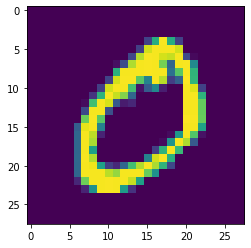

In [ ]:
image,label =dataset[1]
print("image shape",image.shape)
plt.imshow(image.permute(1,2,0))
print("label",label)

In [ ]:
val_size = 10000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])



In [ ]:
batch_size=128


In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

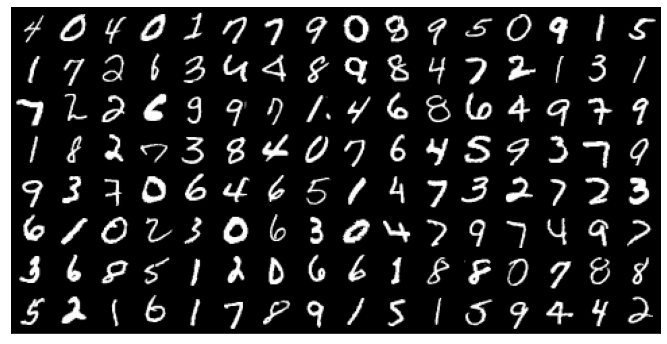

In [ ]:
show_batch(train_loader)

Helper function for trainign and validation

In [ ]:
class ImageClassification(nn.Module):
  def training_step(self,batch):
    image ,labels = batch
    out = self(image)
    loss = F.cross_entropy(out , labels)
    return loss
  
  def validation_step(self,batch):
    image , lables =batch
    out = self(image)
    loss =F.cross_entropy(out, lables)
    acc = accuracy(out,lables)
    return {'val_loss': loss.detach(),'val_acc' : acc}

  def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Define the CNN model

In [ ]:
class MNISTCnnModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))

        self.out= nn.Linear(128*7*7, 10)
           
          
        
    def forward(self, xb):
      xb= self.network(xb)
      xb = xb.view(xb.size(0), -1)       
      xb = self.out(xb)
      return  xb   

     

In [ ]:
cnn =MNISTCnnModel()
cnn

MNISTCnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=6272, out_features=10, bias=True)
)

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = cnn(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0422,  0.0068,  0.0377,  0.0034, -0.0375,  0.0159,  0.0739,  0.0018,
        -0.0036, -0.0029], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(cnn, device);

In [ ]:
@torch.no_grad()
def evaluate(cnn, val_loader):
    cnn.eval()
    outputs = [cnn.validation_step(batch) for batch in val_loader]
    return cnn.validation_epoch_end(outputs)

def fit(epochs, lr, cnn, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(cnn.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        cnn.train()
        train_losses = []
        for batch in train_loader:
            loss = cnn.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(cnn, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        cnn.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
CNNmodel = to_device(MNISTCnnModel(), device)


In [ ]:
evaluate(CNNmodel,val_loader)

{'val_loss': 2.3035759925842285, 'val_acc': 0.09619140625}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, CNNmodel, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.2060, val_loss: 0.0663, val_acc: 0.9819
Epoch [1], train_loss: 0.0502, val_loss: 0.0436, val_acc: 0.9870
Epoch [2], train_loss: 0.0344, val_loss: 0.0474, val_acc: 0.9867
Epoch [3], train_loss: 0.0261, val_loss: 0.0447, val_acc: 0.9872
Epoch [4], train_loss: 0.0208, val_loss: 0.0378, val_acc: 0.9877
Epoch [5], train_loss: 0.0154, val_loss: 0.0385, val_acc: 0.9897
Epoch [6], train_loss: 0.0132, val_loss: 0.0380, val_acc: 0.9896
Epoch [7], train_loss: 0.0121, val_loss: 0.0428, val_acc: 0.9905
Epoch [8], train_loss: 0.0083, val_loss: 0.0467, val_acc: 0.9879
Epoch [9], train_loss: 0.0088, val_loss: 0.0426, val_acc: 0.9887


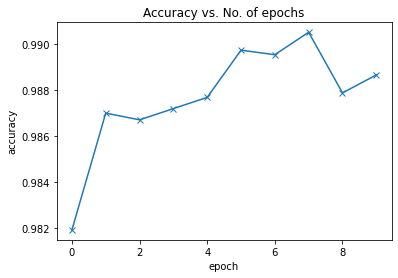

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

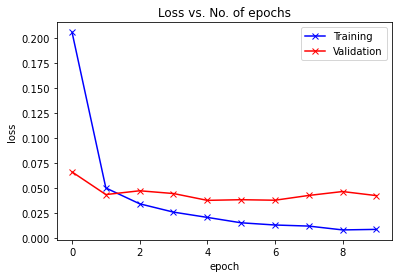

In [ ]:
plot_losses(history)

In [ ]:
from torchvision import transforms 
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


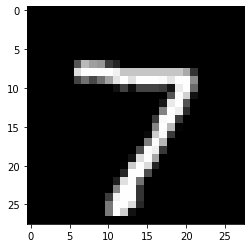

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
def predict_image(img, CNNmodel):
    xb = to_device(img.unsqueeze(0), device)
    yb = CNNmodel(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


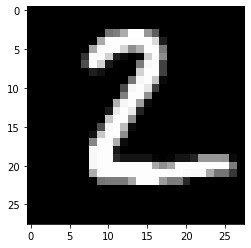

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, CNNmodel))

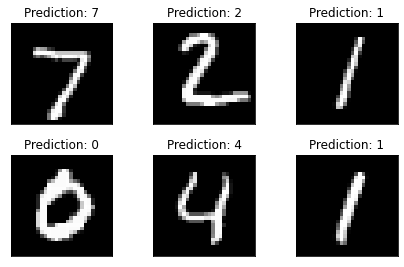

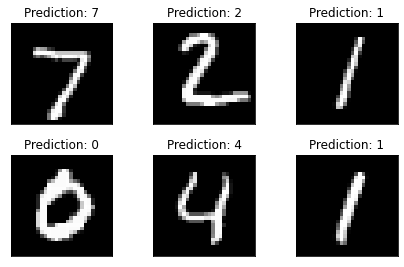

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  img, label = test_dataset[i]
  plt.imshow(img[0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    predict_image(img, CNNmodel)))
  plt.xticks([])
  plt.yticks([])
fig